In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.constants import M_sun, G
import astropy.units as u
import os
top = os.getenv('HOME')+'/codes/dispatch2/'
os.chdir(top+'experiments/ISM/python')


import sys
sys.path.insert(0,top+'utilities/python')
import dispatch as dis
import dispatch.select as dse
import dispatch.graphics as dgr
import dispatch.particles as dpa

sys.path.append('my_funcs/')
from plot_funcs import plot_density, plot_velocity
from calc_funcs import calc_mean_angvec, dist, calc_meanL, patch_diag

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

# Disk size evolution
### This notebook is dedicated to calcute the disk size. The procedure is made from the RAMSES 2017 paper
1. We first calculate the total angular momentum vector $L_{100}$ inside a sphere of 100 au around the protostar
2. Calculate the azimuthal velocity for all cells that are located inside a cylinder of 1000 au in radius and height $\pm 8$ au, and with the radial direction being perpendicular to $L_{100}$
3. Estimate an average azimuthal velocity vf for all cells that are located between radii $r$ and $r + dr$. Consider 100 radial bins with dr increasing exponentially with increasing radius
4. Finally determine the disk size as the radius where $v_\phi v_K$ (with $v_K$ being the Kepler speed) drops below a threshold value a = 0.8

In [2]:
# Create directory containing the snapshots
snaps = {}
i_snap = 710; f_snap = 710 + 1
for io in range(i_snap, f_snap):
    sn = dis.snapshot(io,'my_core_13restart')
    cgs_time = sn.scaling.t / sn.cgs.yr
    snaps[io] = sn
    print(io, f'{sn.time * cgs_time:3.0f} yr')

710 21212 yr


In [3]:
sn = snaps[f_snap - 1]
star_pos = sn.sinks[13][0].position

ds = 0.5**20
w = 200
size = w * ds
extent = size * sn.scaling.l / sn.cgs.au; print(extent,'AU')
cgs_length = sn.scaling.l / sn.cgs.au
cgs_time = sn.scaling.t / sn.cgs.yr 
kms_velocity = (sn.scaling.l / sn.scaling.t) / 1e5 
cgs_density = ((sn.scaling.m/sn.cgs.m_sun) / (sn.scaling.l / sn.cgs.au)**3) / (M_sun.to('kg').value / u.au**3).to('cm**(-3)').value; print(cgs_density)
cgs_density = sn.scaling.d / 0.001; print(cgs_density)
print(sn.scaling.d), print( (sn.scaling.m) / (sn.scaling.l)**3 )


157.38176152030414 AU
9.03259185467041e-06
3.187e-18
3.187e-21
3.187e-21


(None, None)

In [4]:
ρ = dse.amr2raw(sn, center = star_pos, width = w, verbose = 0, lmax = 20, lmin = 15, ivs = 'd')

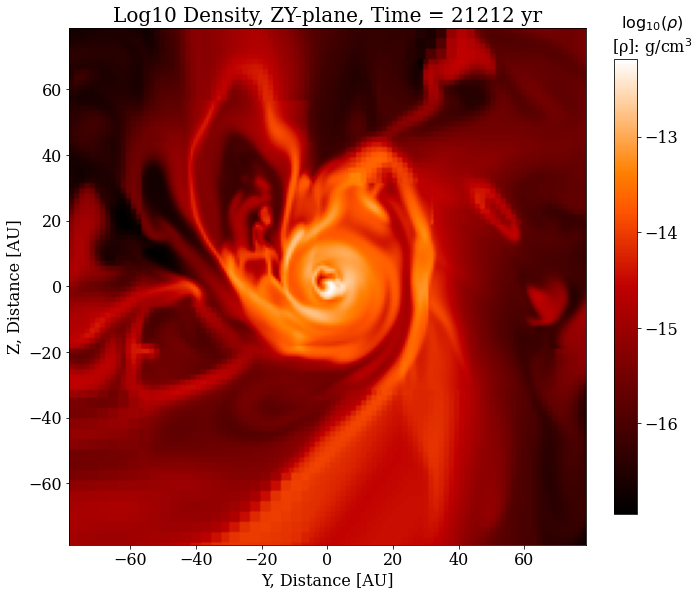

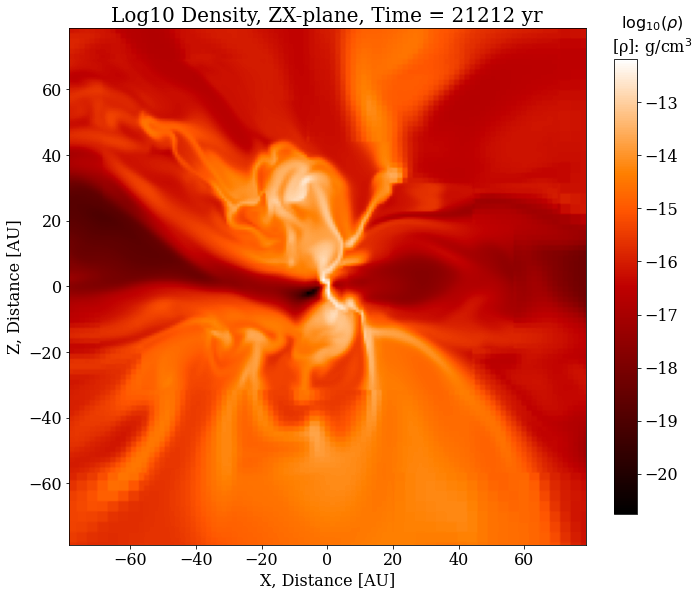

In [5]:
plot_density(ρ, snapshot = sn, width = w, axis = 0)
plot_density(ρ, snapshot = sn, width = w, axis = 1)

### 1. We first calculate the total angular momentum vector $L_{100}$ inside a sphere of 100 au around the protostar

In [7]:
L_100 = calc_meanL(sn, angle_to_calc = np.array([1, 0, 0]), distance=100) #Average over cells

Angle between the given vector and the mean angular momentum vector: 20.1 deg


### 2. Calculate the azimuthal velocity for all cells that are located inside a cylinder of 1000 au in radius and $\pm 8$ au in height, and with the radial direction being perpendicular to $L_{100}$

#### 3D rotation is made from Euler–Rodrigues formula

In [8]:
#https://en.wikipedia.org/wiki/Euler%E2%80%93Rodrigues_formula

import math

def calc_rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


In [9]:
def calc_rotationmatrix(new_axis, axis_to_rotate = np.array([1, 0, 0])):
    angle = np.arccos(np.dot(new_axis, axis_to_rotate)) 
    rotation_axis = np.cross(axis_to_rotate, new_axis)
    return calc_rotation_matrix(rotation_axis, angle)

In [10]:
rotation_matrix2 = calc_rotationmatrix(L_100)
rotation_matrix2 @ np.array([1, 0, 0]), L_100, np.linalg.det(rotation_matrix2) # GREAT

(array([ 0.93927767, -0.28246975,  0.19485457]),
 array([ 0.93927767, -0.28246975,  0.19485457]),
 1.0)

In [11]:
rotation_matrix = calc_rotationmatrix(L_100)

distance = 1.2e3 / cgs_length #Making a shere of 1200 au later to be cut into the cylinder. 

pp_sphere = [p for p in sn.patches if dist(p.position, star_pos) < distance]


height = 8 / cgs_length
radius = 1000 / cgs_length
v_phi = []
patch_dist = []
patch_mass = []
count = 0
for i, p in enumerate(pp_sphere):

    r_vector = p.position - star_pos
    new_position = rotation_matrix @ r_vector


    if np.sqrt(new_position[1]**2 + new_position[2]**2) <= radius and abs(new_position[0]) <= height:
        count += 1

        new_velocity = rotation_matrix @ np.array([p.var('ux').mean(), p.var('uy').mean(), p.var('uz').mean()]) # Big question for the day - should the velocity be transformed and how??
        
        v_phi.append(np.sqrt(new_velocity[1]**2 + new_velocity[2]**2))
        
        patch_dist.append(np.sqrt(new_position[1]**2 + new_position[2]**2) * cgs_length) 
        
        patch_mass.append(p.var('d').mean() * np.prod(p.size))
print(count)
patch_dist = np.array(patch_dist); v_phi = np.array(v_phi); patch_mass = np.array(patch_mass)

126


In [12]:
log_r = np.logspace(1, 3, 100)
mean_vphi = []
evaluted_r = []

prev_r = 5
for i, r in enumerate(log_r):
    index = np.where((patch_dist > prev_r) & (patch_dist < r))[0]
    if len(index) == 0:
        continue
    else:
        bin_mass = np.sum(patch_mass[index])
        mean_vphi.append(np.sum(patch_mass[index] * v_phi[index]) / bin_mass)
        evaluted_r.append(r - 0.5 * (r - prev_r))
        prev_r = r


In [13]:
M_star = sn.sinks[13][0].mass * (sn.scaling.m / sn.cgs.m_sun) * M_sun; print(M_star / M_sun)
kep_vel = (((G * M_star) / (evaluted_r * u.au))**0.5).to('km/s')
kms_velocity = (sn.scaling.l / sn.scaling.t) / 1e5 

evaluted_r = np.array(evaluted_r); mean_vphi = np.array(mean_vphi) * kms_velocity
print(f'Evaluated radii {len(evaluted_r)}')

0.041763120520503856
Evaluated radii 51


## For a thin disk:
### $$v_\phi=v_K\left(1 - O\left(\frac{h}{r}\right)^2\right)^{1/2}\quad\Rightarrow\quad v_\phi < v_K\quad\Leftrightarrow\quad \frac{v_\phi}{v_K}<1$$

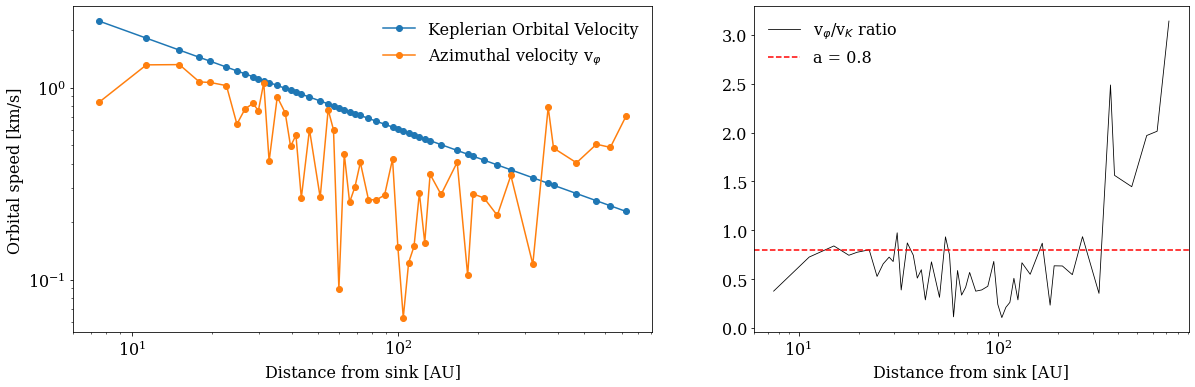

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (20,6),gridspec_kw={'width_ratios': [2, 1.5]})


axs[0].loglog(evaluted_r, kep_vel, label = 'Keplerian Orbital Velocity', marker = 'o')
axs[0].loglog(evaluted_r, mean_vphi, label = 'Azimuthal velocity v$_φ$', marker = 'o')
axs[0].set(xlabel = 'Distance from sink [AU]', ylabel = 'Orbital speed [km/s]')

axs[0].legend(frameon = False)

a = 0.8
axs[1].semilogx(evaluted_r, mean_vphi / kep_vel, label = 'v$_φ$/v$_K$ ratio', color = 'black', lw = 0.8)
axs[1].axhline(a, color = 'red', ls = '--', label = f'a = {a}')
axs[1].set(xlabel = 'Distance from sink [AU]')
axs[1].legend(frameon = False)
#axs[1].

### 2. Calculate the azimuthal velocity for all cells that are located inside a cylinder of 1000 au in radius and $\pm 8$ au in height, and with the radial direction being perpendicular to $L_{100}$<br>BUT now by changing the coordinat system to cylindrical coordinates

In [15]:

e_z = L_100
r = p.position - star_pos
Z_cyl = np.dot(r, e_z)
R_cyl = r - Z_cyl * e_z # Part of r in the θ,r - plane
e_r = R_cyl / np.linalg.norm(R_cyl)
e_θ = np.cross(e_z, e_r)
print(e_θ)


V_patch =  np.array([p.var('ux').mean(), p.var('uy').mean(), p.var('uz').mean()])
V_rel = V_patch - sn.sinks[13][0].velocity

[-0.09146635 -0.75336661 -0.65120862]


In [16]:
pp = []

height = 8 / cgs_length
radius = 1000 / cgs_length
for p in sn.patches:
    r = p.position - star_pos
    z_new = np.dot(r, e_z)
    r_new = r - z_new * e_z
    if abs(z_new) <= height and np.linalg.norm(r_new) <= radius:
        pp.append(p)
    


### What do want to do now? - for looping over the different patches...
- I can not access all data in all pacthes at once so I must loop over each patch to look at each cell
- I can calculate the azimuthal velocity for an entire patch fast and easy and allocate it to the specifed bin - hopefully 1 patch will only touch opun 1 bin and possibly the neighbouring.
- I want to fill up the log grid slowly after "looking" at each patch - so i dont have to loop over both patch and distance.

In [17]:
for p in sn.patches:
    if p.id == 1853:
        break

In [18]:
log_r = np.logspace(1, 3, 100)

r = p.position - star_pos
z_new = np.dot(r, e_z)
r_new = r - z_new * e_z
e_r = r_new / np.linalg.norm(r_new)
e_θ = np.cross(e_z, e_r)


XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
p_r = np.array([XX, YY, ZZ]); 
patch_distances = np.linalg.norm(p_r, axis = 0) 
patch_masses = np.asarray(p.var('d')) * np.prod(p.ds) 
p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)
p_rplane = p_r - p_newz * e_z[:, None, None, None]          # r-coordinate in plane r' = r - ez * r
e_r = p_rplane / np.linalg.norm(p_rplane, axis = 0)         # e_r component (norm = 1)
p_newr = np.sum(e_r * p_r, axis = 0)                        # r-coordinate in new axis (Cylindrical)    
e_φ = np.cross(e_z, e_r, axisa=0, axisb=0, axisc=0)         # e_φ component (norm = 1)


star_vel = sn.sinks[13][0].velocity

p_vrel= np.asarray([p.var('ux') - star_vel[0], p.var('uy') - star_vel[1], p.var('uz') - star_vel[2]]) 
p_vφ = np.sum(p_vrel * e_φ, axis = 0)



[12.59054092 12.59054092 12.59054092]
[12.59054092 12.59054092 12.59054092]


[Text(0.5, 0, 'Distance from star [au]'),
 Text(0, 0.5, 'Azimuthal velocity [km/s]')]

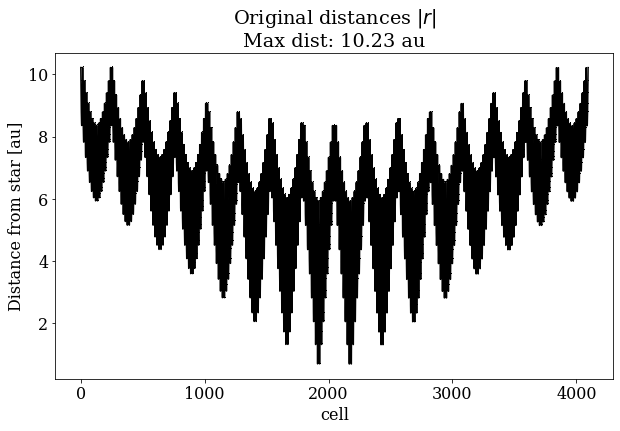

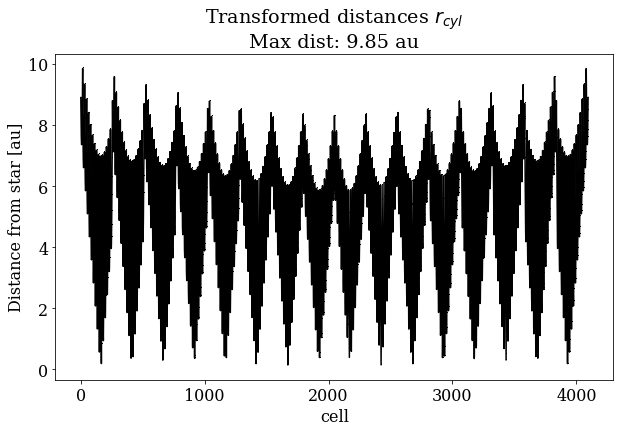

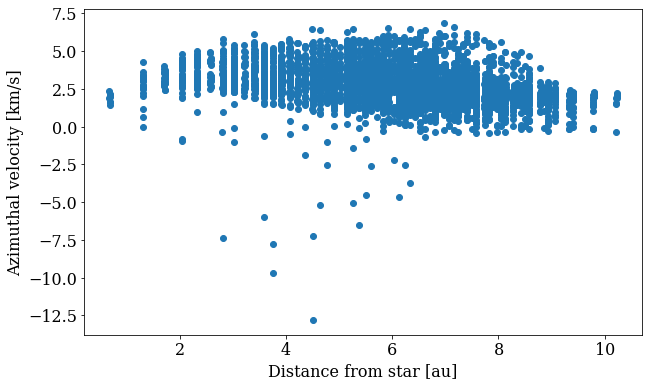

In [19]:
fig,  axs = plt.subplots(figsize = (10,6))
axs.set(ylabel = 'Distance from star [au]', xlabel = 'cell', title = f'Original distances $|r|$\nMax dist: {(patch_distances.flatten() * cgs_length).max():2.2f} au')
axs.plot(patch_distances.flatten() * cgs_length, marker = ',', color = 'black'), print(p.size * cgs_length)


fig,  axs = plt.subplots(figsize = (10,6))
axs.set(ylabel = 'Distance from star [au]', xlabel = 'cell', title = 'Transformed distances $r_{cyl}$'+f'\nMax dist: {(p_newr.flatten() * cgs_length).max():2.2f} au')
axs.plot(p_newr.flatten() * cgs_length, marker = ',', color = 'black'), print(p.size * cgs_length)



fig,  axs = plt.subplots(figsize = (10,6))
axs.scatter(patch_distances.flatten() * cgs_length, p_vφ.flatten() * kms_velocity, )
axs.set(xlabel = 'Distance from star [au]', ylabel = 'Azimuthal velocity [km/s]')

## I belive the transformation to be correct - now I have to loop over all the pacthes
### Doing so I'll only look at each patch **one** time:
    1. Checking it is wihtin the cylinder (from transformation)
    2. Calculate cell masses and azimuthal velocities
    3. Index cells to corresponding radial bin - assign them to the bin. Don't include cells under 10 au r = np.log(1, 3, 100)
    4. Loop over unique indicies from radial bins - should just be a few
    4. DØNE 

In [20]:
r = np.logspace(1, 3, 100) / cgs_length
h_radial = np.histogram(patch_distances, bins = r) # Pretty fugging smart remember np.digitize
h_mass = np.histogram(patch_distances, bins = r, weights =  patch_masses)
h_vφ = np.histogram(patch_distances, bins = r, weights =  p_vφ * patch_masses)

# Creating the "one-time" loop over patches

In [29]:
rad_bins = np.logspace(1, 3, 100) / cgs_length


height = 8 / cgs_length
radius = 1000 / cgs_length
count = 0

h_mass_tot = np.zeros(len(rad_bins) - 1)
h_vφ_tot = np.zeros(len(rad_bins) - 1)
h_vφ_tot2 = np.zeros(len(rad_bins) - 1)
for p in sn.patches:
    r = p.position - star_pos
    z_new = np.dot(r, e_z)
    r_new = r - z_new * e_z
    if abs(z_new) <= height and np.linalg.norm(r_new) <= radius:
        count += 1
        e_r = r_new / np.linalg.norm(r_new)
        e_θ = np.cross(e_z, e_r)

        XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
        p_r = np.array([XX, YY, ZZ]); 

        patch_distances = np.linalg.norm(p_r, axis = 0) 
        patch_masses = np.asarray(p.var('d')) * np.prod(p.ds) 
        p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)
        p_rplane = p_r - p_newz * e_z[:, None, None, None]          # r-coordinate in plane r' = r - ez * r
        e_r = p_rplane / np.linalg.norm(p_rplane, axis = 0)         # e_r component (norm = 1)
        p_newr = np.sum(e_r * p_r, axis = 0)                        # r-coordinate in new axis (Cylindrical)    
        e_φ = np.cross(e_z, e_r, axisa=0, axisb=0, axisc=0)         # e_φ component (norm = 1)
        
        star_vel = sn.sinks[13][0].velocity
        p_vrel= np.asarray([p.var('ux') - star_vel[0], p.var('uy') - star_vel[1], p.var('uz') - star_vel[2]]) 
        p_vφ = np.sum(p_vrel * e_φ, axis = 0)
        
        h_radial, _  = np.histogram(np.linalg.norm(p_rplane, axis = 0), bins = rad_bins)
        h_mass, _ = np.histogram(np.linalg.norm(p_rplane, axis = 0), bins = rad_bins, weights =  patch_masses)
        h_vφ, _ = np.histogram(np.linalg.norm(p_rplane, axis = 0), bins = rad_bins, weights =  p_vφ * patch_masses)
        h_vφ2, _ = np.histogram(np.linalg.norm(p_rplane, axis = 0), bins = rad_bins, weights =  p_vφ**2 * patch_masses)

        h_vφ_tot += h_vφ
        h_mass_tot += h_mass
        h_vφ_tot2 += h_vφ2

#h_vφ_tot = (h_vφ_tot/h_mass_tot) * kms_velocity;
#h_vφ_tot2 = (h_vφ_tot2/h_mass_tot) * kms_velocity**2;

In [30]:
h_mass_tot, h_vφ_tot

(array([2.10900369e-08, 2.17366163e-08, 2.18945000e-08, 2.20374337e-08,
        2.40623058e-08, 2.24942800e-08, 2.34843650e-08, 2.34417743e-08,
        2.40914475e-08, 2.54339609e-08, 2.76733580e-08, 2.86910708e-08,
        2.94649229e-08, 2.98086512e-08, 2.88001979e-08, 3.04512034e-08,
        3.47290076e-08, 4.16506101e-08, 4.17962777e-08, 4.92700735e-08,
        5.42982522e-08, 6.03728668e-08, 7.52128826e-08, 7.90447967e-08,
        8.02401323e-08, 7.21298828e-08, 5.18254342e-08, 4.12406375e-08,
        3.62035485e-08, 3.16975150e-08, 2.96392417e-08, 2.91197042e-08,
        2.85427879e-08, 2.31047518e-08, 2.23112094e-08, 2.16587250e-08,
        2.12889791e-08, 1.85116954e-08, 1.49421206e-08, 1.36932759e-08,
        1.34459083e-08, 1.43075531e-08, 1.40689464e-08, 1.53973479e-08,
        1.49965059e-08, 1.94486501e-08, 2.93710413e-08, 3.38596170e-08,
        3.31323081e-08, 2.99495007e-08, 2.96539372e-08, 2.87212017e-08,
        2.68139426e-08, 2.52075142e-08, 2.23891634e-08, 1.784589

In [22]:
r_plot = rad_bins[:-1] + 0.5 * np.diff(rad_bins)
M_star = sn.sinks[13][0].mass * (sn.scaling.m / sn.cgs.m_sun) * M_sun; print(M_star / M_sun)
kep_vel = (((G * M_star) / (r_plot * cgs_length * u.au))**0.5).to('km/s')
kms_velocity = (sn.scaling.l / sn.scaling.t) / 1e5 

0.041763120520503856


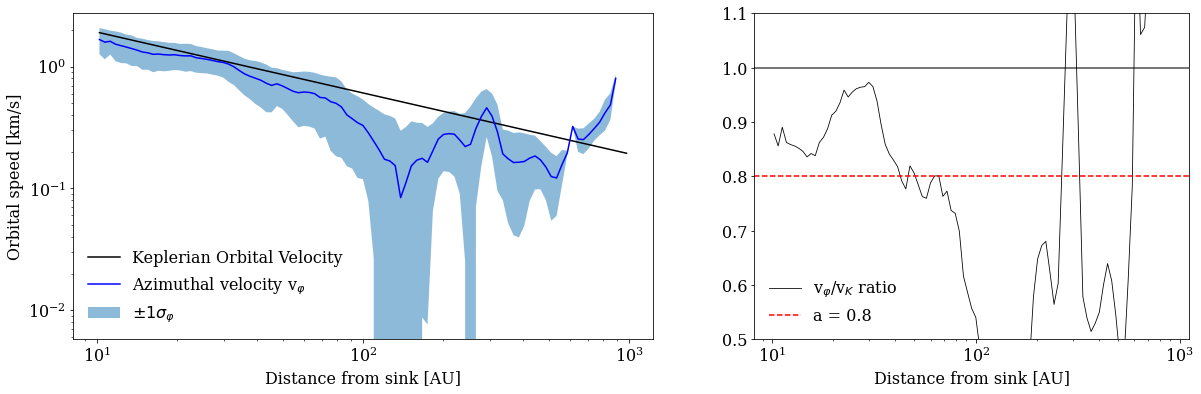

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (20,6),gridspec_kw={'width_ratios': [2, 1.5]})

σ_φ = np.sqrt(h_vφ_tot2 - h_vφ_tot**2)

axs[0].loglog(r_plot * cgs_length, kep_vel, label = 'Keplerian Orbital Velocity', color = 'black')
axs[0].loglog(r_plot * cgs_length, h_vφ_tot , label = 'Azimuthal velocity v$_φ$', c = 'blue')
axs[0].fill_between(r_plot * cgs_length, h_vφ_tot - σ_φ, h_vφ_tot + σ_φ, alpha = 0.5, label = '$\pm1\sigma_{φ}$')



axs[0].set(xlabel = 'Distance from sink [AU]', ylabel = 'Orbital speed [km/s]')

axs[0].legend(frameon = False)

a = 0.8
axs[1].semilogx(r_plot * cgs_length, h_vφ_tot / kep_vel, label = 'v$_φ$/v$_K$ ratio', color = 'black', lw = 0.8)
axs[1].axhline(a, color = 'red', ls = '--', label = f'a = {a}')
axs[1].axhline(1, color = 'black', ls = '-', alpha = 0.7)
axs[1].set(xlabel = 'Distance from sink [AU]', ylim = (0.5, 1.1))
axs[1].legend(frameon = False)

In [24]:
rad_bins = np.logspace(1, 3, 100) / cgs_length


height = 8 / cgs_length
radius = 1000 / cgs_length
count = 0

h_mass_tot = np.zeros(len(rad_bins) - 1)
h_vφ_tot = np.zeros(len(rad_bins) - 1)
h_vφ_tot2 = np.zeros(len(rad_bins) - 1)
for p in sn.patches:
    r = p.position - star_pos
    z_new = np.dot(r, e_z)
    r_new = r - z_new * e_z
    if abs(z_new) <= height and np.linalg.norm(r_new) <= radius:
        count += 1
        e_r = r_new / np.linalg.norm(r_new)
        e_θ = np.cross(e_z, e_r)

        XX, YY, ZZ = np.meshgrid(p.xi - star_pos[0], p.yi - star_pos[1], p.zi - star_pos[2], indexing='ij')
        p_r = np.array([XX, YY, ZZ]); 

        patch_distances = np.linalg.norm(p_r, axis = 0) 
        patch_masses = np.asarray(p.var('d')) * np.prod(p.ds) 
        p_newz = np.sum(e_z[:, None, None, None] * p_r, axis = 0)   # z-coordinate in new axis (Cylindrical)
        p_rplane = p_r - p_newz * e_z[:, None, None, None]          # r-coordinate in plane r' = r - ez * r
        e_r = p_rplane / np.linalg.norm(p_rplane, axis = 0)         # e_r component (norm = 1)
        p_newr = np.sum(e_r * p_r, axis = 0)                        # r-coordinate in new axis (Cylindrical)    
        e_φ = np.cross(e_z, e_r, axisa=0, axisb=0, axisc=0)         # e_φ component (norm = 1)
        
        star_vel = sn.sinks[13][0].velocity
        p_vrel= np.asarray([p.var('ux') - star_vel[0], p.var('uy') - star_vel[1], p.var('uz') - star_vel[2]]) 
        p_vφ = np.sum(p_vrel * e_φ, axis = 0)
        
        h_radial, _  = np.histogram(patch_distances, bins = rad_bins)
        h_mass, _ = np.histogram(patch_distances, bins = rad_bins, weights =  patch_masses)
        h_vφ, _ = np.histogram(patch_distances, bins = rad_bins, weights =  np.log(abs(p_vφ)) * patch_masses)
        sign_h_vφ, _ = np.histogram(patch_distances, bins = rad_bins, weights =  p_vφ * patch_masses)
        h_vφ2, _ = np.histogram(patch_distances, bins = rad_bins, weights =   np.log(p_vφ**2) * patch_masses)



        not_nan_idx = np.nonzero(np.isnan(np.sign(sign_h_vφ) * h_vφ) - 1)
        h_mass_tot += h_mass
        h_vφ_tot[not_nan_idx] +=  np.sign(sign_h_vφ)[not_nan_idx] * h_vφ[not_nan_idx]
        h_vφ_tot2 += h_vφ2
       #if (h_vφ < 0).any():        break


h_vφ_tot = (h_vφ_tot/h_mass_tot);
h_vφ_tot2 = (h_vφ_tot2/h_mass_tot);

/tmp/ipykernel_1713462/3893664990.py:50: RuntimeWarning: invalid value encountered in true_divide
  h_vφ_tot = (h_vφ_tot/h_mass_tot);
/tmp/ipykernel_1713462/3893664990.py:51: RuntimeWarning: invalid value encountered in true_divide
  h_vφ_tot2 = (h_vφ_tot2/h_mass_tot);


In [25]:

r_plot = rad_bins[:-1] + 0.5 * np.diff(rad_bins)
M_star = sn.sinks[13][0].mass * (sn.scaling.m / sn.cgs.m_sun) * M_sun; print(M_star / M_sun)
kep_vel = (((G * M_star) / (r_plot * cgs_length * u.au))**0.5).to('km/s')
kms_velocity = (sn.scaling.l / sn.scaling.t) / 1e5 

0.041763120520503856


/tmp/ipykernel_1713462/2504223208.py:4: RuntimeWarning: invalid value encountered in sqrt
  σ_φ = np.sqrt(h_vφ_tot2 - h_vφ_tot**2)


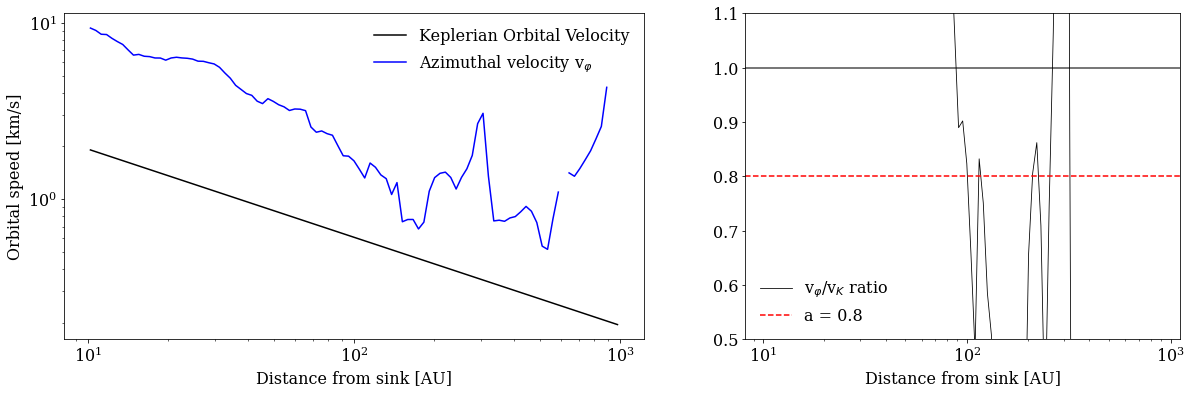

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (20,6),gridspec_kw={'width_ratios': [2, 1.5]})


σ_φ = np.sqrt(h_vφ_tot2 - h_vφ_tot**2)

axs[0].loglog(r_plot * cgs_length, kep_vel, label = 'Keplerian Orbital Velocity', color = 'black')
axs[0].loglog(r_plot * cgs_length, np.exp(h_vφ_tot) , label = 'Azimuthal velocity v$_φ$', c = 'blue')
#axs[0].fill_between(r_plot * cgs_length, h_vφ_tot - σ_φ, h_vφ_tot + σ_φ, alpha = 0.5, label = '$\pm1\sigma_{φ}$')
#axs[0].errorbar(r_plot * cgs_length, y = h_vφ_tot, yerr = σ_φ)


axs[0].set(xlabel = 'Distance from sink [AU]', ylabel = 'Orbital speed [km/s]')

axs[0].legend(frameon = False)

a = 0.8
axs[1].semilogx(r_plot * cgs_length, h_vφ_tot / kep_vel, label = 'v$_φ$/v$_K$ ratio', color = 'black', lw = 0.8)
axs[1].axhline(a, color = 'red', ls = '--', label = f'a = {a}')
axs[1].axhline(1, color = 'black', ls = '-', alpha = 0.7)
axs[1].set(xlabel = 'Distance from sink [AU]', ylim = (0.5, 1.1))
axs[1].legend(frameon = False)